## Text Mining of OHW Project Readme's

In this notebook we explore the patterns in the text of the OHW Projects READMEs. We will extract topics and low dimensional representations so that we can create a scatter plot and cluster the projects.

We use data scraped from the OHW github repos, which is stored in a `.json` file.

In [99]:
import pandas as pd

In [100]:
import numpy as np

In [101]:
import matplotlib.pyplot as plt

In [102]:
# df = pd.read_csv("project_list_final.csv")

In [103]:
# setting up text mining packages

In [54]:
!pip install nltk

In [104]:
import nltk

In [105]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [106]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [107]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [108]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [110]:
import json

# check what is in the json
# from pprint import pprint

# with open('readmes_proj_ohw.json') as json_data:
#    d = json.load(json_data)
#    json_data.close()
#    #pprint(d)

In [111]:
#data = json.load("readmes_proj_ohw.json")

In [112]:
df = pd.read_json("readmes_proj_ohw.json", typ='series')

In [113]:
proj_names = [(name.strip('https://github.com/oceanhackweek/')) for name in list(df.index)]

In [114]:
df[0]

/tmp/ipykernel_845/2680116315.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'## ohw21-proj-model-subsampling\n## OceanHackWeek21 project to subsample high-resolution model output as if by gliders, ships, or other in situ platforms\n\nThe goal of this project is to create a Python package that takes an input trajectory (e.g., the path of an ocean glider), subsamples output from a high-resolution ocean simulation along that trajectory, and returns a set of subsampled variables (e.g., standard physical variables temperature, salinity, velocity; derived physical quantities such as steric height; biogeochemical quantities if available).  We envision this package having two potential uses: 1) designing *in situ* sampling strategies, and 2) interpreting *in situ* data in the context of a highly resolved oceanographic model.\n\nTasks:\n1. Load model data from a specific region (e.g., ROMS output in the California Current from CenOOS; MITgcm regional llc4320 data)\n2. Create simulated trajectory file\n3. Obtain real trajectory file\n4. Interpolate model data to the tra

In [115]:
# function to preprocess the readmes

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def readme_preprocess(readme):
    
    # tokenize
    tokens = tokenizer.tokenize(readme)
    
    # make lower case
    tokens = [tok.lower() for tok in tokens]
    
    # stem
    lancaster = nltk.LancasterStemmer()
    tokens = [lancaster.stem(tok) for tok in tokens]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [tok for tok in tokens if tok not in stop_words]
    
    return(tokens)

In [116]:
# preprocess each readme
readmes = [readme_preprocess(readme) for readme in list(df)]

In [117]:
# converting to string
final_readmes = []
for readme in readmes:
    for word in readme:
        n = readme.index(word)
        if n == 0:
            string = readme[n]
        else:
            string = string + " " + readme[n]
    final_readmes.append(string)

## Topic Modeling with Nonnegative Matrix Factorization

We will try a simple method to extract topics from `scikit-learn` library.

The approach involves creat a Term Frequency - Inverse Document Frequency matrix, which is factorized into topics and weights.

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)

In [125]:

tfidf_matrix = tfidf_vectorizer.fit_transform(final_readmes)

In [126]:
tfidf_matrix.shape

(50, 675)

In [127]:
n_topics = 10

from sklearn.decomposition import NMF
model = NMF(init="nndsvd", n_components=n_topics, random_state=1)
W_matrix = model.fit_transform(tfidf_matrix)
H_matrix = model.components_

In [128]:
# Print topics and keywords
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_index in range( H_matrix.shape[0] ):
    top_indices = np.argsort( H_matrix[topic_index,:] )[::-1][0:10]  ##show top 10 words associated with each topic
    term_ranking = [tfidf_feature_names[i] for i in top_indices]
    print ("Topic %d: %s" % ( topic_index, ", ".join( term_ranking ) ))

Topic 0: shar, ad, structure, particip, dataset, project, link, fold, team, nee
Topic 1: dat, process, grady, model, oc, saildron, thi, may, us, output
Topic 2: prod, ohw22, nutry, clust, templ, process, org, ohw, habit, impact
Topic 3: https, com, github, www, 14, detect, io, spat, copernic, atl
Topic 4: deep, im, satellit, cur, cnn, method, us, estim, lstm, predict
Topic 5: imo, dat, moor, plot, websit, ap, s3, amazonaw, prefix, southeast
Topic 6: acoust, pac, pass, dataset, som, imo, avail, serv, dat, link
Topic 7: de, los, ohw22, prod, en, las, ind, del, github, discuss
Topic 8: point, brazil, coast, sou, sim, transect, sum, reg, model, dispers
Topic 9: gcm, 2021, oceanhackweek, filt, environ, pangeo, readthedoc, latest, ohw, yaml


### Nonlinear Dimensionality Reduction with T-SNE

Next we will reduce the dimension from 10 (topics) to 2D so we can plot in a scatter plot.

In [129]:
from sklearn.manifold import TSNE

In [130]:
W_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(W_matrix)
W_embedded.shape

(50, 2)

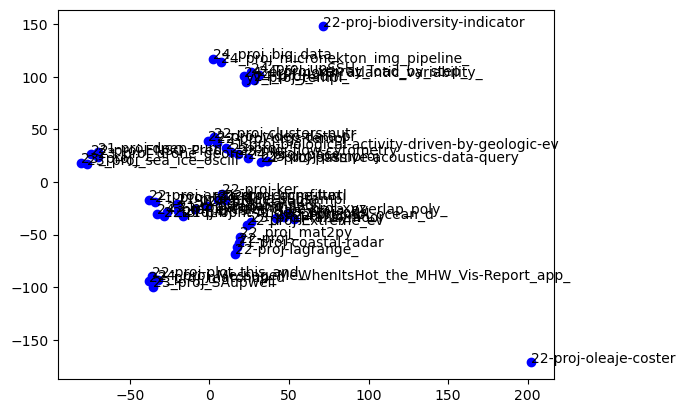

In [131]:
fig, ax = plt.subplots()
ax.plot(W_embedded[:,0], W_embedded[:,1], "bo")
for i, txt in enumerate(proj_names):
    ax.annotate(txt, (W_embedded[i,0], W_embedded[i,1]))

## Plotly Visualization

This is clearly not readable! Let's use Plotly to visualize the labels better

In [132]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [133]:
# organize in a dataframe
d = {'x': W_embedded[:,0], 'y': W_embedded[:,1], 'proj_name': proj_names}
df_2D = pd.DataFrame(data=d)

In [134]:
import plotly.io as pio
pio.renderers.default = 'notebook'

In [96]:
import plotly.express as px

fig = px.scatter(df_2D, x="x", y="y",  hover_name="proj_name")

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='OHW Projects'
)

fig.show()

Q: Why is `21-proj-coastal-radar` an outlier?

A: They did not fill their README!!!

https://github.com/oceanhackweek/ohw21-proj-coastal-radar

ohw21-proj-coastal-radar

Participants

Panagiotis Mitsopoulos

Filipe Pereira

Anrijs Abele

Teresa Updyke

Mauricio Rocha

presentation.ipynb is the main notebook, with a description of the project and some preliminary results.

In [97]:
# pip install -U kaleido